In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
def init_matplotlib():
    """Just some Matplotlib settings."""
    plt.style.use('seaborn')
    #matplotlib.rcParams["figure.figsize"] = (15, 6)
    #matplotlib.rcParams["figure.dpi"] = 300
    #matplotlib.rcParams["font.size"] = 32
    #matplotlib.rcParams["axes.titlesize"] = 'x-large'
init_matplotlib()

In [3]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [4]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

In [5]:
# the predictors are relaesed on Friday, add 3 days to align
spot = custom_read_csv('spot.csv').drop('Unnamed: 3', axis=1).dropna()
supply = custom_read_csv('productsupplied.csv').dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors = pd.concat([spot, supply, stocks], axis=1)
predictors.index = predictors.index + pd.DateOffset(days=3)

In [6]:
yearly_price = price.national.groupby(price.index.year).median()

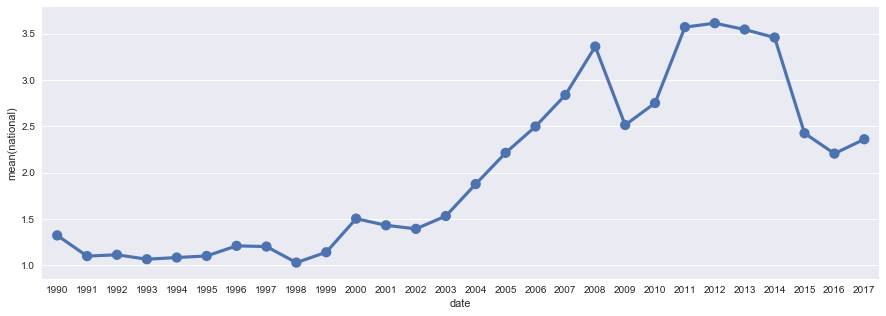

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(yearly_price.index.astype(int), yearly_price, ax=ax)
plt.show()

In [11]:
correls = pd.concat([price.national, predictors], axis=1).rolling(window=250).corr()
correls.columns.names = ['series2']
correls.index.names = ['date', 'series1']
correls = correls.loc[(slice(None), 'national'),:].dropna().drop('national', axis=1)

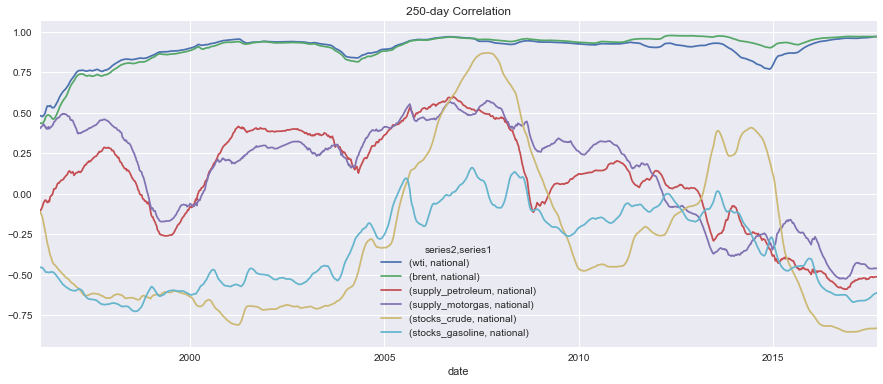

In [26]:
correls.unstack().dropna().plot(figsize=(15,6), title='250-day Correlation')
plt.show()

In [86]:
def regress(predictor, response, start, end, halflife, returnr2=False):
    '''
        helper function to run regression
        predictor: dataframe of predictors
        response: series of response
        start: start date
        end: end date
        halflife: halflife to weight regression exponentially
    '''
    y = response[start:end].values
    X = predictor[start:end].values
    
    assert X.shape[0] == y.shape[0], "predictor and response are not the same length"
    
    w = np.ones(y.shape)
    decay = 2.0 ** (-1.0/halflife)
    for i in range(len(w)-2, -1, -1):
        w[i] = w[i+1] * decay
    
    reg = LinearRegression(normalize=True)
    reg.fit(X, y, sample_weight=w)
    if returnr2:
        return (reg, reg.score(X,y))
    return reg

In [90]:
# Rolling regression

window = 500
halflife = 250
dates = price.national['1992-01-01':'2010-12-31'].index

coef_arr = np.ones((len(dates), len(predictors.columns))) * np.nan
r2_arr = np.ones(len(dates)) * np.nan
reg = np.empty(len(dates), dtype=object)
for t in range(window, len(dates)):
    reg[t], r2_arr[t] = regress(predictors, price.national, dates[t-window], dates[t], halflife, returnr2=True)
    coef_arr[t] = reg[t].coef_
r2 = pd.Series(r2_arr, index=dates, name='r2').dropna()
coef = pd.DataFrame(coef_arr, index=dates, columns=predictors.columns).dropna()
regobj = pd.Series(reg[window:], index=dates[window:], name='regress_object')

In [127]:
df = pd.concat([pd.Series(dates[window:], index=regobj.index, name='date'), 
                regobj], axis=1).shift(1).dropna()

In [141]:
prediction = df.apply(lambda x: x.regress_object.predict(predictors.loc[x.date].values.reshape(1,-1)), axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

In [165]:
corr_prediction_actual = pd.concat([price.national, prediction], axis=1).rolling(
    window=250).corr().dropna().loc[(slice(None), 'national'),'date']

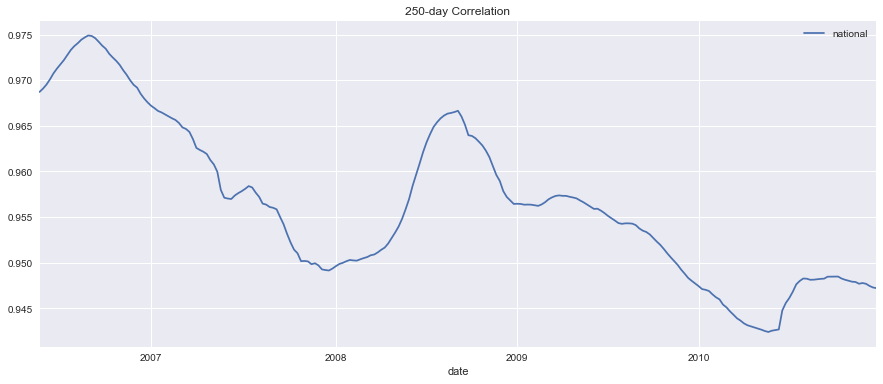

In [167]:
corr_prediction_actual.unstack().dropna().plot(figsize=(15,6), title='250-day Correlation')
plt.show()

In [173]:
acf_1week = pd.concat([price.national, price.national.shift(1).rename('lagged')], axis=1).rolling(
    window=250).corr().dropna().loc[(slice(None), 'national'),'lagged']

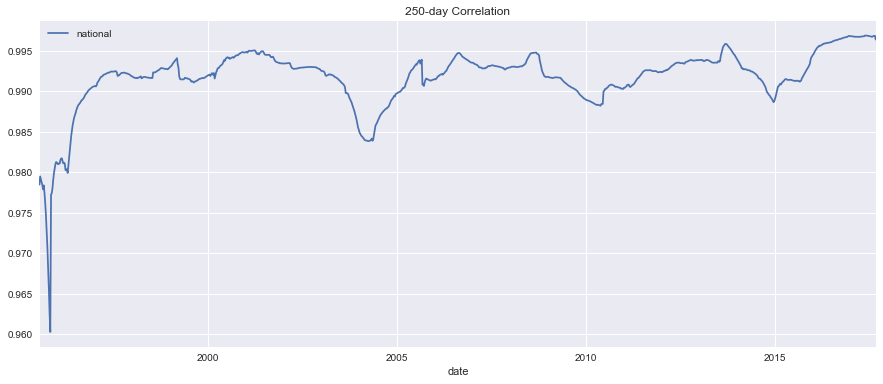

In [174]:
acf_1week.unstack().dropna().plot(figsize=(15,6), title='250-day Correlation')
plt.show()